In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
# 将数据归一化到0到1之间
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# 将数据从二维数组转换为一维向量
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


11490434/11490434 [==============================] - 0s 0us/step


In [3]:
# 定义输入层和编码层维度
input_dim = x_train.shape[1]
encoding_dim = 32

# 定义模型权重
input_layer = tf.keras.layers.Input(shape=(input_dim,))
encoder_layer = tf.keras.layers.Dense(encoding_dim, activation='relu')(input_layer)
decoder_layer = tf.keras.layers.Dense(input_dim, activation='sigmoid')(encoder_layer)

# 定义自动编码器模型
autoencoder = tf.keras.models.Model(inputs=input_layer, outputs=decoder_layer)

# 定义编码器模型，从原始输入到编码层
encoder = tf.keras.models.Model(inputs=input_layer, outputs=encoder_layer)

# 编译模型
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [5]:
# 训练模型
history = autoencoder.fit(x_train, x_train,
                          epochs=20,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_test, x_test))


Epoch 1/20
235/235 [==============================] - 2s 11ms/step - loss: 0.0946 - val_loss: 0.0931
Epoch 2/20
235/235 [==============================] - 2s 7ms/step - loss: 0.0943 - val_loss: 0.0928
Epoch 3/20
235/235 [==============================] - 2s 7ms/step - loss: 0.0940 - val_loss: 0.0927
Epoch 4/20
235/235 [==============================] - 2s 7ms/step - loss: 0.0939 - val_loss: 0.0925
Epoch 5/20
235/235 [==============================] - 2s 10ms/step - loss: 0.0937 - val_loss: 0.0923
Epoch 6/20
235/235 [==============================] - 2s 7ms/step - loss: 0.0936 - val_loss: 0.0922
Epoch 7/20
235/235 [==============================] - 2s 7ms/step - loss: 0.0935 - val_loss: 0.0922
Epoch 8/20
235/235 [==============================] - 2s 7ms/step - loss: 0.0934 - val_loss: 0.0922
Epoch 9/20
235/235 [==============================] - 2s 7ms/step - loss: 0.0934 - val_loss: 0.0921
Epoch 10/20
235/235 [==============================] - 2s 7ms/step - loss: 0.0933 - val_loss: 0.09

In [6]:
encoded_imgs = encoder.predict(x_test)


313/313 [==============================] - 0s 842us/step


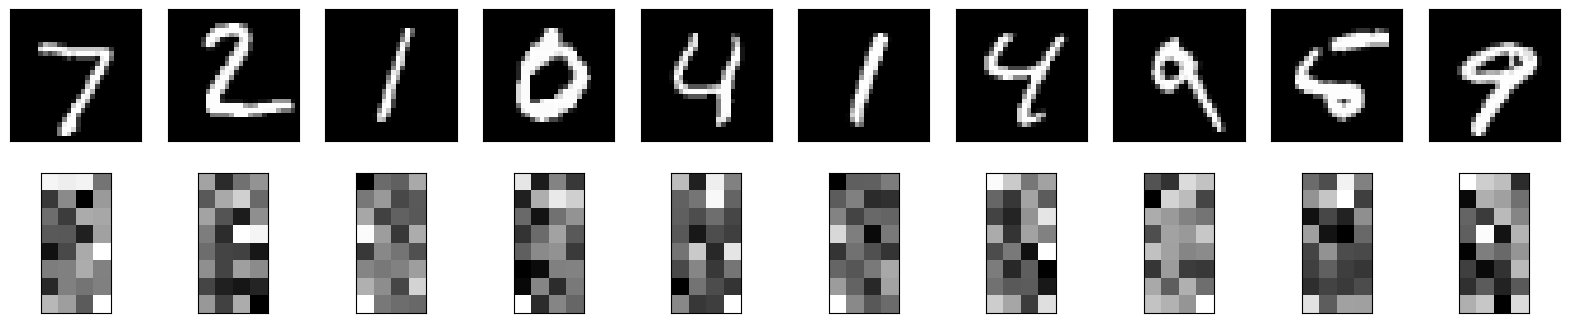

In [7]:
n = 10  # 展示10张图像
plt.figure(figsize=(20, 4))
for i in range(n):
    # 展示原始图像
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 展示编码和解码后的图像
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(8, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


## 使用堆叠式自动编码器的无监督预训练

In [12]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = tf.reshape(x_train, (len(x_train), 28*28))

x_test = tf.reshape(x_test, (len(x_test), 28*28))


In [24]:
class Autoencoder(tf.keras.Model):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoding_dim = encoding_dim   
        self.encoder = tf.keras.Sequential([
          tf.keras.layers.Dense(encoding_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
          tf.keras.layers.Dense(784, activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [25]:
lr = 0.001
epochs = 10
batch_size = 256


In [26]:
autoencoder = Autoencoder(encoding_dim=64)

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), loss='binary_crossentropy')


In [27]:
stacked_autoencoder = tf.keras.Sequential([
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
])

stacked_autoencoder.build((None, 784))

stacked_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), loss='binary_crossentropy')


In [28]:
autoencoder1 = Autoencoder(encoding_dim=256)
autoencoder2 = Autoencoder(encoding_dim=128)
autoencoder3 = Autoencoder(encoding_dim=64)

autoencoder1.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), loss='binary_crossentropy')
autoencoder2.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), loss='binary_crossentropy')
autoencoder3.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), loss='binary_crossentropy')

history1 = autoencoder1.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test, x_test))

encoded_1 = autoencoder1.encoder(x_train)
encoded_2 = autoencoder2.encoder(encoded_1)
encoded_3 = autoencoder3.encoder(encoded_2)

stacked_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(lr=lr), loss='binary_crossentropy')

history2 = stacked_autoencoder.fit(encoded_2, encoded_3,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(encoded_2, encoded_3))


Epoch 1/10
235/235 [==============================] - 4s 15ms/step - loss: 0.1852 - val_loss: 0.1110
Epoch 2/10
235/235 [==============================] - 4s 17ms/step - loss: 0.0974 - val_loss: 0.0860
Epoch 3/10
235/235 [==============================] - 3s 14ms/step - loss: 0.0819 - val_loss: 0.0771
Epoch 4/10
235/235 [==============================] - 3s 14ms/step - loss: 0.0755 - val_loss: 0.0729
Epoch 5/10
235/235 [==============================] - 3s 14ms/step - loss: 0.0721 - val_loss: 0.0706
Epoch 6/10
235/235 [==============================] - 5s 20ms/step - loss: 0.0701 - val_loss: 0.0691
Epoch 7/10
235/235 [==============================] - 3s 14ms/step - loss: 0.0689 - val_loss: 0.0680
Epoch 8/10
235/235 [==============================] - 3s 14ms/step - loss: 0.0680 - val_loss: 0.0673
Epoch 9/10
235/235 [==============================] - 4s 17ms/step - loss: 0.0673 - val_loss: 0.0667
Epoch 10/10
235/235 [==============================] - 3s 14ms/step - loss: 0.0668 - val_lo

Epoch 1/10


ValueError: ignored